# Proyecto 04 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.


### Mejoras para el Proyecto 4:

- Tenemos como modelo GANADOR del Proeycto 3 el RandomForestRegressor con GridSearchCV modelo que presenta un mejor RMSE en Test  4177.69 y en Train tiene un RMSE de 4620.45 lo que da signos de no estar overfitting.
- Se agregarán los datos sobre `Feriados`, `Dias_de_Semana` y `Paro`.
- Se utilizarán las variables más relevantes.


### Mejores y desafíos a resolver: 
El modelo anterior fue realizado como una primera aproximación y montado sobre arrays de numpy `crudos` realizado de manera manual, sobre los cuales montamos los atributos principales y entrenamos un primer borrador de modelo con un `RandomForest` sin ningún tipo de biblioteca, ni depuración de variables o seleccion de atributos o embebido de variables extras que pudieran ayudar a la prediccion; por lo que en este trabajo realizaremos las mejoras pertinentes en ese sentido. 

### Lista de Modificaciones pendientes:
1. Agregaremos informacion externa al dataset, informacion categorica sobre fechas especiales `Feriados`, `Dias_de_Semana` y `Paro`, con el objetivo de mejorar la prediccion.
2. Realizaremos una depuracion, dejando las variables mas relevantes para el modelo y dejando espacio para nuevos atributos
3. Implementaremos Polinomios y PCA y ver su interaccion y resultados en performance.
4. Finalmente, productivizar e implementar un nuevo modelo, similar, utilizando la bibioteca `prophet` de facebook, de manera de hacer todo este proceso mucho mas acelerado, computacionalmente eficiente, escalable, e iterable para el modelado, comparando ventajas y desventajas y como desempeña en comparacion con el modelo anterior. 
______________________________

## 1.Preparacion Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

%matplotlib inline

from statsmodels.tsa.ar_model import AR,ARResults


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [3]:
# Importando Data 
df = pd.read_csv('Datos_Illia_Procesados.csv', sep =',')


In [4]:
# Transfomar columna fecha a índice.

df.index = pd.to_datetime(df.fecha)

# Se indica que la frecuencia es diaria.
df = df.resample("D").sum().copy()

In [12]:
df

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0
...,...
2019-12-27,40182.0
2019-12-28,30681.0
2019-12-29,26259.0


In [13]:
# Test Dick Fuller

adfuller(df.cantidad_pasos)

(-1.7304491540237308,
 0.4154963568410881,
 20,
 1074,
 {'1%': -3.4364533503600962,
  '5%': -2.864234857527328,
  '10%': -2.568204837482531},
 21299.332596280994)

####
El resultado del test Dick Fuller me da como resultado que la serie no es estacionaria, dado que el p-valor es muy alto mayor a cero.

## 2. Utilización de Modelo AR

- Se utilizará el modelo de Auto Regresivo AR para comparar con el modelo ganador del Proyecto 3.

### Graficar la serie de datos

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


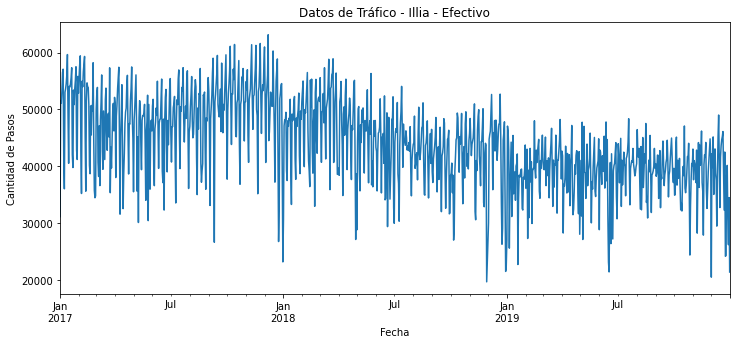

In [14]:
# Graficar la serie

title = "Datos de Tráfico - Illia - Efectivo"
xlabel = "Fecha"
ylabel = "Cantidad de Pasos"

ax=df["cantidad_pasos"].plot(figsize=(12,5), title=title);
ax.autoscale(axis="x", tight=True)
ax.set(xlabel = xlabel, ylabel = ylabel);


#### ACF y PACF

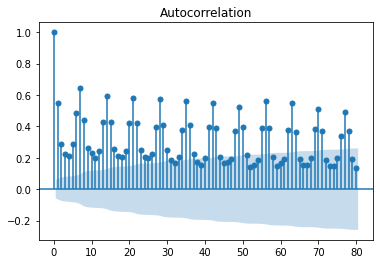

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
a = plot_acf(df.cantidad_pasos.values, lags = 80, alpha=.05)
a.figsize=(20,3)

Si importamos StatsModels y analizamos el correlograma validamos parte de este comportamiento. 
Hay un comportamiento recursivo cada 8 dias, la observacion t-8 y la observacion inmediatamente anterior t-1 estás fuertemente correlacionada con la fecha en curso. Luego este movimiento sigue de manera recursiva en el tiempo.

Lo anterior se confirmar al realizar el análisis de Partial Autocorrelation.

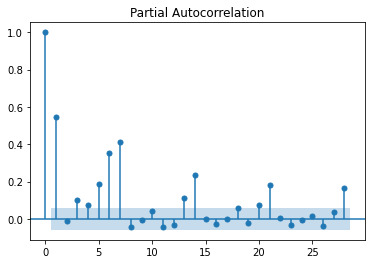

In [16]:
a = plot_pacf(df.cantidad_pasos.values, lags = 28, alpha=.05)


### Separar los Datos en Train y Test

In [17]:
# Cantidad de filas del dataframe
len(df)

1095

In [18]:
# Calcular el 80%
1095*0.8

876.0

In [19]:
train = df.iloc[:876]
test = df.iloc[876:]

## Aplicar el Modelo AR

### - Modelo AR(1)

- Para comenzar lo probaremos con un maxlag = 1, este será nuestro punto de partida, es decir el Modelo AR será de orden 1.

In [20]:
# Ignorar Warnings
import warnings
warnings.filterwarnings("ignore")

In [21]:
model = AR(train["cantidad_pasos"])
   

In [22]:
model1 = AR(train["cantidad_pasos"])
AR1fit = model1.fit(maxlag=1, method="mle")
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients: \n{AR1fit.params}')


Lag: 1
Coefficients: 
const                21689.950703
L1.cantidad_pasos        0.520038
dtype: float64


In [23]:
start = len(train)
end = len(train) + len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename("AR(1) Predictions")

In [24]:
predictions1

2019-05-27    39741.518942
2019-05-28    42357.061245
2019-05-29    43717.243325
2019-05-30    44424.590053
2019-05-31    44792.437418
                  ...     
2019-12-27    45190.999826
2019-12-28    45190.999826
2019-12-29    45190.999826
2019-12-30    45190.999826
2019-12-31    45190.999826
Freq: D, Name: AR(1) Predictions, Length: 219, dtype: float64

In [25]:
#Comparando predicciones con valores reales

for i in range(len(predictions1)):
    print(f'predicted={predictions1[i]:11.10} expected ={test["cantidad_pasos"][i]}')

predicted=39741.51894 expected =37985.0
predicted=42357.06124 expected =39739.0
predicted=43717.24332 expected =40353.5
predicted=44424.59005 expected =40968.0
predicted=44792.43742 expected =44849.0
predicted=44983.73212 expected =28884.0
predicted=45083.21269 expected =42876.0
predicted=45134.94639 expected =42536.0
predicted= 45161.8499 expected =39250.0
predicted=45175.84075 expected =36846.0
predicted=45183.11652 expected =41869.0
predicted=45186.90021 expected =39498.0
predicted=45188.86787 expected =39122.0
predicted=45189.89113 expected =45311.0
predicted=45190.42326 expected =36198.0
predicted=45190.69999 expected =40257.0
predicted= 45190.8439 expected =47811.0
predicted=45190.91874 expected =37476.0
predicted=45190.95766 expected =44731.0
predicted= 45190.9779 expected =31277.0
predicted=45190.98842 expected =23190.0
predicted= 45190.9939 expected =21469.0
predicted=45190.99674 expected =34656.0
predicted=45190.99822 expected =40686.0
predicted=45190.99899 expected =26438.0


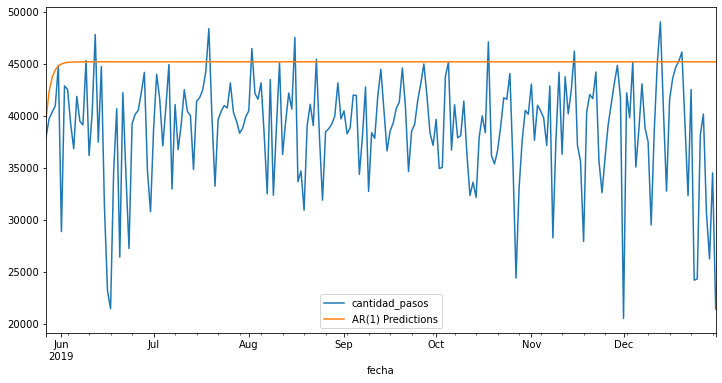

In [26]:
test["cantidad_pasos"].plot(legend=True)
predictions1.plot(legend=True, figsize=(12,6));

#### COMENTARIO:

- El Modelo AR con 1 maxlag no es el mejor predictor para la serie de tiempo que estamos utilizando. 
- Se seguirá probando con otros números de maxlag para ver cómo es la performance.


### - Modelo AR(2)

- Intentaremos nuevamente, pero con un Modelo AR de orden 2.

In [27]:
model2 = AR(train["cantidad_pasos"])

In [28]:
AR2fit = model2.fit(maxlag=2, method="mle")
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients: \n{AR2fit.params}')
    

Lag: 2
Coefficients: 
const                23024.246019
L1.cantidad_pasos        0.560230
L2.cantidad_pasos       -0.069778
dtype: float64


In [29]:
start = len(train)
end = len(train) + len(test)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename("AR(2) Predictions")

In [30]:
predictions2

2019-05-27    39985.027554
2019-05-28    43002.911977
2019-05-29    44325.678800
2019-05-30    44856.149880
2019-05-31    45061.035400
                  ...     
2019-12-27    45185.598992
2019-12-28    45185.598992
2019-12-29    45185.598992
2019-12-30    45185.598992
2019-12-31    45185.598992
Freq: D, Name: AR(2) Predictions, Length: 219, dtype: float64

In [31]:
#Comparando predicciones con valores reales

for i in range(len(predictions2)):
    print(f'predicted={predictions2[i]:11.10} expected ={test["cantidad_pasos"][i]}')

predicted=39985.02755 expected =37985.0
predicted=43002.91198 expected =39739.0
predicted= 44325.6788 expected =40353.5
predicted=44856.14988 expected =40968.0
predicted= 45061.0354 expected =44849.0
predicted= 45138.8031 expected =28884.0
predicted=45168.07435 expected =42876.0
predicted= 45179.0465 expected =42536.0
predicted=45183.15092 expected =39250.0
predicted=45184.68473 expected =36846.0
predicted=45185.25762 expected =41869.0
predicted=45185.47154 expected =39498.0
predicted=45185.55141 expected =39122.0
predicted=45185.58123 expected =45311.0
predicted=45185.59236 expected =36198.0
predicted=45185.59652 expected =40257.0
predicted=45185.59807 expected =47811.0
predicted=45185.59865 expected =37476.0
predicted=45185.59886 expected =44731.0
predicted=45185.59894 expected =31277.0
predicted=45185.59897 expected =23190.0
predicted=45185.59899 expected =21469.0
predicted=45185.59899 expected =34656.0
predicted=45185.59899 expected =40686.0
predicted=45185.59899 expected =26438.0


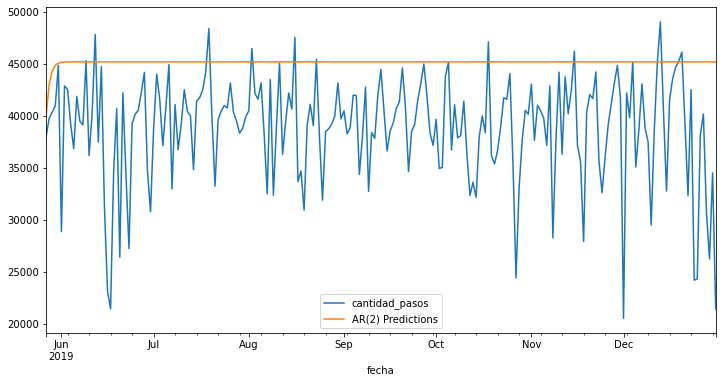

In [32]:
test["cantidad_pasos"].plot(legend=True)
predictions2.plot(legend=True, figsize=(12,6));

#### COMENTARIO:

- El Modelo AR con 2 maxlag no es el mejor predictor para la serie de tiempo que estamos utilizando. 
- Se seguirá probando con otros números de maxlag para ver cómo es la performance.
- No es sufience el retraso de 2 observaciones, y se entiende por la magnitud de los datos y su estacionalidad.

### - Modelo AR(8)

- Se seleccionarán 8 observaciones, de acuerdo a lo que se puede observar en el análisis de Autocorrelación.

In [33]:
model8 = AR(train["cantidad_pasos"])

In [34]:
AR8fit = model8.fit(maxlag=8, method="mle")
print(f'Lag: {AR8fit.k_ar}')
print(f'Coefficients: \n{AR8fit.params}')

Lag: 8
Coefficients: 
const                5812.349830
L1.cantidad_pasos       0.337289
L2.cantidad_pasos      -0.079941
L3.cantidad_pasos       0.033945
L4.cantidad_pasos      -0.006762
L5.cantidad_pasos       0.012852
L6.cantidad_pasos       0.157453
L7.cantidad_pasos       0.456984
L8.cantidad_pasos      -0.040766
dtype: float64


In [35]:
start = len(train)
end = len(train) + len(test)-1
predictions8 = AR8fit.predict(start=start, end=end, dynamic=False).rename("AR(8) Predictions")

In [36]:
predictions8

2019-05-27    37933.572606
2019-05-28    38491.647607
2019-05-29    40734.716464
2019-05-30    42926.356880
2019-05-31    43009.562298
                  ...     
2019-12-27    45062.926931
2019-12-28    45063.284595
2019-12-29    45063.643376
2019-12-30    45063.999779
2019-12-31    45064.345233
Freq: D, Name: AR(8) Predictions, Length: 219, dtype: float64

In [37]:
#Comparando predicciones con valores reales

for i in range(len(predictions8)):
    print(f'predicted={predictions8[i]:11.10} expected ={test["cantidad_pasos"][i]}')

predicted=37933.57261 expected =37985.0
predicted=38491.64761 expected =39739.0
predicted=40734.71646 expected =40353.5
predicted=42926.35688 expected =40968.0
predicted= 43009.5623 expected =44849.0
predicted=38405.26357 expected =28884.0
predicted=37387.44055 expected =42876.0
predicted=39026.38313 expected =42536.0
predicted=40008.74079 expected =39250.0
predicted=41554.09007 expected =36846.0
predicted=42923.33316 expected =41869.0
predicted=42494.52818 expected =39498.0
predicted=40039.57528 expected =39122.0
predicted=39275.10467 expected =45311.0
predicted=40154.69341 expected =36198.0
predicted=41075.07602 expected =40257.0
predicted=42182.07962 expected =47811.0
predicted=42980.56612 expected =37476.0
predicted=42538.54622 expected =44731.0
predicted=41143.52261 expected =31277.0
predicted=40629.00063 expected =23190.0
predicted=41138.84079 expected =21469.0
predicted=41876.87771 expected =34656.0
predicted= 42665.4259 expected =40686.0
predicted=43125.42153 expected =26438.0


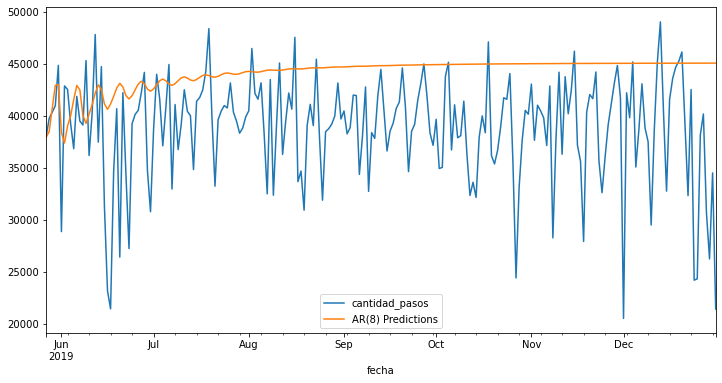

In [38]:
test["cantidad_pasos"].plot(legend=True)
predictions8.plot(legend=True, figsize=(12,6));

### - Modelo AR(180)

- Se seleccionarán 180 observaciones que correspoden a un semestre.

In [39]:
model180 = AR(train["cantidad_pasos"])

In [40]:
AR180fit = model180.fit(maxlag=180, method="mle")
print(f'Lag: {AR180fit.k_ar}')
print(f'Coefficients: \n{AR180fit.params}')

NameError: name 'AR180fit' is not defined

In [ ]:
start = len(train)
end = len(train) + len(test)-1
predictions180 = AR180fit.predict(start=start, end=end, dynamic=False).rename("AR(180) Predictions")

In [ ]:
predictions180

In [ ]:
#Comparando predicciones con valores reales

for i in range(len(predictions180)):
    print(f'predicted={predictions180[i]:11.10} expected ={test["cantidad_pasos"][i]}')

In [ ]:
test["cantidad_pasos"].plot(legend=True)
predictions180.plot(legend=True, figsize=(12,6));

### - Modelo AR(p)

- El modelo eligirá el maxlen más adecuado.

In [41]:
ARfit = model.fit(ic="bic")
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients: \n{ARfit.params}')

Lag: 14
Coefficients: 
const                 4140.967045
L1.cantidad_pasos        0.315279
L2.cantidad_pasos       -0.039302
L3.cantidad_pasos       -0.000129
L4.cantidad_pasos       -0.015006
L5.cantidad_pasos        0.061028
L6.cantidad_pasos        0.126502
L7.cantidad_pasos        0.319939
L8.cantidad_pasos       -0.061964
L9.cantidad_pasos       -0.050781
L10.cantidad_pasos       0.064997
L11.cantidad_pasos      -0.007550
L12.cantidad_pasos      -0.078377
L13.cantidad_pasos       0.026060
L14.cantidad_pasos       0.245650
dtype: float64


In [42]:
start = len(train)
end = len(train) + len(test)-1
rename= f"AR(14) Predictions"

predictions14 = ARfit.predict(start=start, end=end, dynamic=False).rename(rename)

<AxesSubplot:xlabel='fecha'>

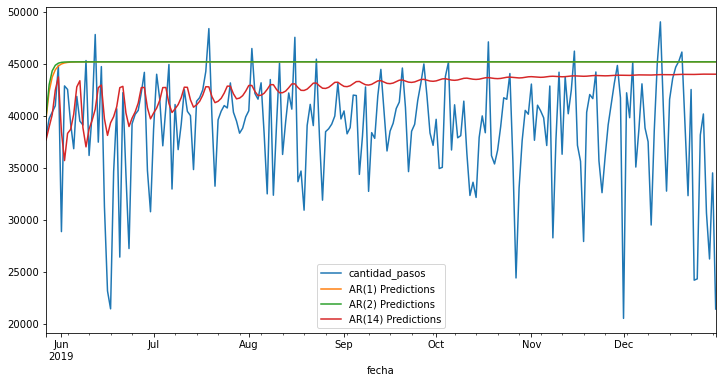

In [43]:
test["cantidad_pasos"].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions14.plot(legend=True, figsize =(12,6))


In [44]:
from sklearn.metrics import mean_squared_error

labels = ["AR(1)", "AR(2)","AR(8)","AR(180)", "AR(14)"]
preds = [predictions1, predictions2, predictions8,predictions180, predictions14]

for i in range(5):
    rmse = np.sqrt(mean_squared_error(test["cantidad_pasos"], preds[i]))
    print(f'{labels[i]} RMSE: {rmse:11.10}')
    


NameError: name 'predictions180' is not defined

#### Comentarios:

- Se evaluó el modelo AR para distintos maxlag, siendo el mejor resultado el lag de 180 muestras con un RMSE en Test de 5.249.
- El resultado del modelo Ganador del Proyecto 3 tiene mejor desempeño que el modelo AR.


- Modelo Ganador: 
Train: 4.620.-
Test: 4.177.-

- Modelo AR(180):
Test 5.249.-

- El Modelo de AR no tiene una buena performance en series no estacionarias, como es el caso de las serie de este análisis.


## Aplicar el Modelo ARMA

Se utilizará este modelo para ver el desempeño en la serie no estacionaria.

In [47]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.graphics.tsaplots as sgt


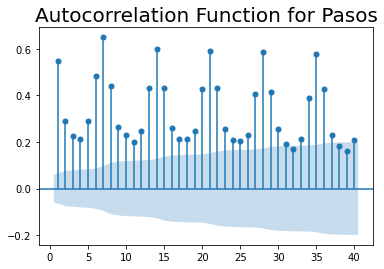

In [48]:
sgt.plot_acf(df.cantidad_pasos, unbiased=True, zero=False, lags= 40)
plt.title("Autocorrelation Function for Pasos", size = 20)
plt.show()

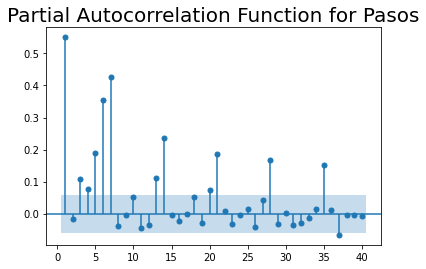

In [49]:
sgt.plot_pacf(df.cantidad_pasos, zero=False, lags= 40, alpha= 0.05, method=("ols"))
plt.title("Partial Autocorrelation Function for Pasos", size = 20)
plt.show()

#### Modelo ARMA(1,1)

Se evaluará un modelo ARMA con parámetros de (1,1)

In [50]:
model_ar1_ma1=ARMA(df.cantidad_pasos, order =(1,1))
results_ar1_ma1=model_ar1_ma1.fit()
results_ar1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         cantidad_pasos   No. Observations:                 1095
Model:                     ARMA(1, 1)   Log Likelihood              -11133.265
Method:                       css-mle   S.D. of innovations           6299.721
Date:                Tue, 19 Oct 2021   AIC                          22274.530
Time:                        16:45:08   BIC                          22294.524
Sample:                    01-01-2017   HQIC                         22282.095
                         - 12-31-2019                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.394e+04    413.977    106.131      0.000    4.31e+04    4.47e+04
ar.L1.cantidad_pasos     0.5198      0.055      9.398      0.000       0.411       0.628
ma.L1.cantidad_pasos     0.0454      0.068      0.663      0.507      -0.089       0.180
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9240           +0.0000j            1.9240            0.0000
MA.1          -22.0417           +0.0000j           22.0417            0.5000
-----------------------------------------------------------------------------
"""

El Modelo ARMA (1,1) tiene un p-valor no significativo, por lo que no es un buen modelo para predecir.

#### Modelo ARMA(4,3)

Se evaluará un modelo ARMA con parámetros de (4,3), en concordancia con los resultados de ACF y PACF.

In [51]:
model_ar4_ma3=ARMA(df.cantidad_pasos, order =(4,3))
results_ar4_m3=model_ar4_ma3.fit()
results_ar4_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         cantidad_pasos   No. Observations:                 1095
Model:                     ARMA(4, 3)   Log Likelihood              -10907.117
Method:                       css-mle   S.D. of innovations           5107.721
Date:                Tue, 19 Oct 2021   AIC                          21832.234
Time:                        16:45:13   BIC                          21877.221
Sample:                    01-01-2017   HQIC                         21849.257
                         - 12-31-2019                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.394e+04   3988.746     11.015      0.000    3.61e+04    5.18e+04
ar.L1.cantidad_pasos     2.3794      0.003    747.834      0.000       2.373       2.386
ar.L2.cantidad_pasos    -2.5454      0.006   -398.168      0.000      -2.558      -2.533
ar.L3.cantidad_pasos     1.2983      0.006    207.196      0.000       1.286       1.311
ar.L4.cantidad_pasos    -0.1337      0.003    -48.345      0.000      -0.139      -0.128
ma.L1.cantidad_pasos    -2.1834      0.015   -146.889      0.000      -2.212      -2.154
ma.L2.cantidad_pasos     2.1547      0.020    106.021      0.000       2.115       2.195
ma.L3.cantidad_pasos    -0.9247      0.014    -65.974      0.000      -0.952      -0.897
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6239           -0.7817j            1.0002           -0.1428
AR.2            0.6239           +0.7817j            1.0002            0.1428
AR.3            1.0020           -0.0000j            1.0020           -0.0000
AR.4            7.4643           -0.0000j            7.4643           -0.0000
MA.1            0.6315           -0.7840j            1.0066           -0.1421
MA.2            0.6315           +0.7840j            1.0066            0.1421
MA.3            1.0672           -0.0000j            1.0672           -0.0000
-----------------------------------------------------------------------------
"""

In [52]:
start = len(train)
end = len(train) + len(test)-1
rename= f"results_ar4_m3(14) Predictions"

predictions_ar4_m3 = results_ar4_m3.predict(start=start, end=end, dynamic=False).rename(rename)

In [53]:
print(f'Lag: {predictions_ar4_m3}')
print(f'Coefficients: \n{results_ar4_m3.params}')

Lag: fecha
2019-05-27    35880.870217
2019-05-28    38118.902720
2019-05-29    40609.842042
2019-05-30    41706.096791
2019-05-31    40900.193925
                  ...     
2019-12-27    40017.615906
2019-12-28    38140.911406
2019-12-29    34557.299415
2019-12-30    33403.913732
2019-12-31    36400.654579
Freq: D, Name: results_ar4_m3(14) Predictions, Length: 219, dtype: float64
Coefficients: 
const                   43935.636393
ar.L1.cantidad_pasos        2.379381
ar.L2.cantidad_pasos       -2.545366
ar.L3.cantidad_pasos        1.298309
ar.L4.cantidad_pasos       -0.133650
ma.L1.cantidad_pasos       -2.183351
ma.L2.cantidad_pasos        2.154682
ma.L3.cantidad_pasos       -0.924709
dtype: float64


In [54]:
#test["cantidad_pasos"].plot(legend=True)
#results_ar4_m3.plot(legend=True, figsize =(12,6))

In [55]:
labels = ["results_ar4_m3"]
preds = [predictions_ar4_m3]

for i in range(1):
    rmse = np.sqrt(mean_squared_error(test["cantidad_pasos"], preds[i]))
    print(f'{labels[i]} RMSE: {rmse:11.10}')

results_ar4_m3 RMSE: 4756.883639


#### Modelo ARMA(3,4)

Se evaluará un modelo ARMA con parámetros de (3,4), en concordancia con los resultados de ACF y PACF.

In [56]:
model_ar3_ma4=ARMA(df.cantidad_pasos, order =(3,4))
results_ar3_m4=model_ar3_ma4.fit()
results_ar3_m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         cantidad_pasos   No. Observations:                 1095
Model:                     ARMA(3, 4)   Log Likelihood              -10982.734
Method:                       css-mle   S.D. of innovations           5472.484
Date:                Tue, 19 Oct 2021   AIC                          21983.468
Time:                        16:45:24   BIC                          22028.454
Sample:                    01-01-2017   HQIC                         22000.490
                         - 12-31-2019                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.394e+04   4088.508     10.746      0.000    3.59e+04    5.19e+04
ar.L1.cantidad_pasos     0.5554      0.002    264.228      0.000       0.551       0.560
ar.L2.cantidad_pasos    -0.5561      0.002   -296.991      0.000      -0.560      -0.552
ar.L3.cantidad_pasos     0.9975      0.002    536.654      0.000       0.994       1.001
ma.L1.cantidad_pasos    -0.1670      0.026     -6.352      0.000      -0.219      -0.115
ma.L2.cantidad_pasos     0.3864      0.017     22.198      0.000       0.352       0.421
ma.L3.cantidad_pasos    -0.7444      0.018    -42.079      0.000      -0.779      -0.710
ma.L4.cantidad_pasos    -0.3542      0.026    -13.510      0.000      -0.406      -0.303
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0013           -0.0000j            1.0013           -0.0000
AR.2           -0.2219           -0.9757j            1.0006           -0.2856
AR.3           -0.2219           +0.9757j            1.0006            0.2856
MA.1            1.0378           -0.0000j            1.0378           -0.0000
MA.2           -0.2146           -0.9787j            1.0019           -0.2844
MA.3           -0.2146           +0.9787j            1.0019            0.2844
MA.4           -2.7102           -0.0000j            2.7102           -0.5000
-----------------------------------------------------------------------------
"""

In [57]:
start = len(train)
end = len(train) + len(test)-1
rename= f"results_ar3_m4 Predictions"

predictions_ar3_m4 = results_ar3_m4.predict(start=start, end=end, dynamic=False).rename(rename)

In [58]:
print(f'Lag: {predictions_ar3_m4}')
print(f'Coefficients: \n{results_ar3_m4.params}')

Lag: fecha
2019-05-27    38567.818516
2019-05-28    39964.424767
2019-05-29    38258.077380
2019-05-30    38709.971746
2019-05-31    40899.377012
                  ...     
2019-12-27    40213.682628
2019-12-28    38629.695887
2019-12-29    35259.948160
2019-12-30    35367.010587
2019-12-31    37907.970020
Freq: D, Name: results_ar3_m4 Predictions, Length: 219, dtype: float64
Coefficients: 
const                   43935.655184
ar.L1.cantidad_pasos        0.555388
ar.L2.cantidad_pasos       -0.556149
ar.L3.cantidad_pasos        0.997549
ma.L1.cantidad_pasos       -0.167011
ma.L2.cantidad_pasos        0.386392
ma.L3.cantidad_pasos       -0.744363
ma.L4.cantidad_pasos       -0.354181
dtype: float64


In [59]:
#test["cantidad_pasos"].plot(legend=True)
#results_ar3_m4.plot(legend=True, figsize =(12,6))

In [60]:
labels = ["results_ar3_m4"]
preds = [predictions_ar3_m4]

for i in range(1):
    rmse = np.sqrt(mean_squared_error(test["cantidad_pasos"], preds[i]))
    print(f'{labels[i]} RMSE: {rmse:11.10}')

results_ar3_m4 RMSE: 4977.288731


Análisis de Residuos

In [61]:
df["resid_ar4_m3"] = results_ar4_m3.resid

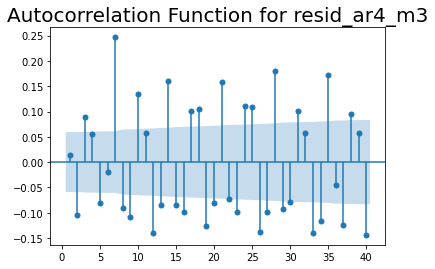

In [62]:
sgt.plot_acf(df.resid_ar4_m3, unbiased=True, zero=False, lags= 40)
plt.title("Autocorrelation Function for resid_ar4_m3", size = 20)
plt.show()

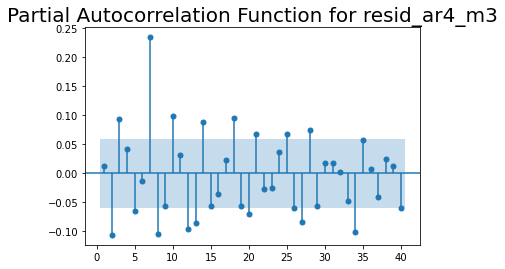

In [63]:
sgt.plot_pacf(df.resid_ar4_m3, zero=False, lags= 40, alpha= 0.05, method=("ols"))
plt.title("Partial Autocorrelation Function for resid_ar4_m3", size = 20)
plt.show()

In [64]:
model_ar7_ma6=ARMA(df.cantidad_pasos, order =(7,6))
#results_ar14_m14=model_ar14_ma14.fit()
results_ar7_m6=model_ar7_ma6.fit(start_ar_lags=14)
results_ar7_m6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         cantidad_pasos   No. Observations:                 1095
Model:                     ARMA(7, 6)   Log Likelihood              -10820.277
Method:                       css-mle   S.D. of innovations           4682.402
Date:                Tue, 19 Oct 2021   AIC                          21670.555
Time:                        16:45:57   BIC                          21745.532
Sample:                    01-01-2017   HQIC                         21698.925
                         - 12-31-2019                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.394e+04   9293.056      4.728      0.000    2.57e+04    6.21e+04
ar.L1.cantidad_pasos     1.0328      0.027     38.922      0.000       0.981       1.085
ar.L2.cantidad_pasos    -0.6341      0.022    -28.690      0.000      -0.677      -0.591
ar.L3.cantidad_pasos     0.1085      0.015      7.344      0.000       0.080       0.137
ar.L4.cantidad_pasos     0.4376      0.010     43.467      0.000       0.418       0.457
ar.L5.cantidad_pasos    -0.8971      0.015    -59.951      0.000      -0.926      -0.868
ar.L6.cantidad_pasos     1.1750      0.022     52.820      0.000       1.131       1.219
ar.L7.cantidad_pasos    -0.2242      0.027     -8.437      0.000      -0.276      -0.172
ma.L1.cantidad_pasos    -0.7732      0.013    -57.562      0.000      -0.800      -0.747
ma.L2.cantidad_pasos     0.4693      0.003    166.983      0.000       0.464       0.475
ma.L3.cantidad_pasos     0.0361      0.006      5.734      0.000       0.024       0.048
ma.L4.cantidad_pasos    -0.4235      0.009    -49.293      0.000      -0.440      -0.407
ma.L5.cantidad_pasos     0.8403      0.001    628.868      0.000       0.838       0.843
ma.L6.cantidad_pasos    -0.9427      0.012    -76.377      0.000      -0.967      -0.918
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0034           -0.0000j            1.0034           -0.5000
AR.2           -0.2217           -0.9754j            1.0003           -0.2856
AR.3           -0.2217           +0.9754j            1.0003            0.2856
AR.4            0.6242           -0.7815j            1.0002           -0.1427
AR.5            0.6242           +0.7815j            1.0002            0.1427
AR.6            1.0005           -0.0000j            1.0005           -0.0000
AR.7            4.4389           -0.0000j            4.4389           -0.0000
MA.1           -1.0000           -0.0000j            1.0000           -0.5000
MA.2           -0.2145           -0.9767j            1.0000           -0.2844
MA.3           -0.2145           +0.9767j            1.0000            0.2844
MA.4            0.6298           -0.7768j            1.0000           -0.1416
MA.5            0.6298           +0.7768j            1.0000            0.1416
MA.6            1.0608           -0.0000j            1.0608           -0.0000
-----------------------------------------------------------------------------
"""

In [65]:
start = len(train)
end = len(train) + len(test)-1
rename= f"results_ar7_m6 Predictions"

predictions_ar7_m6 = results_ar7_m6.predict(start=start, end=end, dynamic=False).rename(rename)

In [66]:
print(f'Lag: {predictions_ar7_m6}')
print(f'Coefficients: \n{results_ar7_m6.params}')

Lag: fecha
2019-05-27    35713.468444
2019-05-28    38650.521253
2019-05-29    39366.451936
2019-05-30    40267.516021
2019-05-31    42866.998558
                  ...     
2019-12-27    39301.766315
2019-12-28    37627.306421
2019-12-29    34626.153334
2019-12-30    33992.676130
2019-12-31    37099.613838
Freq: D, Name: results_ar7_m6 Predictions, Length: 219, dtype: float64
Coefficients: 
const                   43935.654380
ar.L1.cantidad_pasos        1.032809
ar.L2.cantidad_pasos       -0.634082
ar.L3.cantidad_pasos        0.108472
ar.L4.cantidad_pasos        0.437578
ar.L5.cantidad_pasos       -0.897121
ar.L6.cantidad_pasos        1.175048
ar.L7.cantidad_pasos       -0.224204
ma.L1.cantidad_pasos       -0.773217
ma.L2.cantidad_pasos        0.469282
ma.L3.cantidad_pasos        0.036067
ma.L4.cantidad_pasos       -0.423496
ma.L5.cantidad_pasos        0.840272
ma.L6.cantidad_pasos       -0.942659
dtype: float64


In [67]:
labels = ["results_ar7_m6"]
preds = [predictions_ar7_m6]

for i in range(1):
    rmse = np.sqrt(mean_squared_error(test["cantidad_pasos"], preds[i]))
    print(f'{labels[i]} RMSE: {rmse:11.10}')

results_ar7_m6 RMSE: 4744.624742


In [68]:
# Comparación de los Modelos ARMA

print("ARMA(4,4): \t LL = ", results_ar3_m4.llf, "\t AIC = ", results_ar3_m4.aic)
print("ARMA(7,6): \t LL = ", results_ar7_m6.llf, "\t AIC = ", results_ar7_m6.aic)

ARMA(4,4): 	 LL =  -10982.733926328207 	 AIC =  21983.467852656413
ARMA(7,6): 	 LL =  -10820.27728054876 	 AIC =  21670.55456109752


#### Comentarios:
Se evaluó el modelo ARMA, obteniendo:

-El Modelo ARMA(7,6) tiene mejor resultado que ARMA(3,4).

-El resultado del modelo Ganador del Proyecto 3 tiene mejor desempeño que el modelo ARMA.

-Modelo Ganador: Train: 4.620.- Test: 4.177.-

-Modelo AR(180): Test 5.249.-

-El Modelo de ARMA con  análisis de residuos "results_ar7_m6"  tiene un RMSE de 4744.624742.

### Modelo ARIMA

Se utilizará el Modelo ARIMA que tiene un mejor desempeño en series no estacionarias.

- Empezar con el modelo más simple ARIMA(1,1,1).
- Examinar residuos.
- Complejizar.
- Bajar el número de componentes.


In [69]:
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

In [70]:
def LLR_test(mod_1, mod_2, DF =1):
    L1=mod_1.llf
    L2=mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p


In [71]:
model_ar1_i1_ma1 = ARIMA(df.cantidad_pasos, order=(1,1,1))
results_ar1_i1_ma1 = model_ar1_i1_ma1.fit()
results_ar1_i1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.cantidad_pasos   No. Observations:                 1094
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11047.175
Method:                       css-mle   S.D. of innovations           5871.745
Date:                Tue, 19 Oct 2021   AIC                          22102.350
Time:                        16:45:59   BIC                          22122.340
Sample:                    01-02-2017   HQIC                         22109.914
                         - 12-31-2019                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -11.2717      6.269     -1.798      0.072     -23.559       1.015
ar.L1.D.cantidad_pasos     0.3140      0.030     10.384      0.000       0.255       0.373
ma.L1.D.cantidad_pasos    -0.9768      0.007   -142.731      0.000      -0.990      -0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1847           +0.0000j            3.1847            0.0000
MA.1            1.0238           +0.0000j            1.0238            0.0000
-----------------------------------------------------------------------------
"""

In [72]:
start = len(train)
end = len(train) + len(test)-1
rename= f"results_ar1_i1_ma1 Predictions"

predictions_ar1_i1_ma1 = results_ar1_i1_ma1.predict(start=start, end=end, dynamic=False).rename(rename)

In [73]:
print(f'Lag: {predictions_ar1_i1_ma1}')
print(f'Coefficients: \n{results_ar1_i1_ma1.params}')

Lag: fecha
2019-05-27    2511.711339
2019-05-28     276.390380
2019-05-29    -900.244070
2019-05-30   -1294.316415
2019-05-31   -1679.229094
                 ...     
2019-12-27      63.137828
2019-12-28   -1280.856972
2019-12-29    5038.047197
2019-12-30    7843.928747
2019-12-31    2176.842048
Freq: D, Name: results_ar1_i1_ma1 Predictions, Length: 219, dtype: float64
Coefficients: 
const                    -11.271704
ar.L1.D.cantidad_pasos     0.313998
ma.L1.D.cantidad_pasos    -0.976756
dtype: float64


In [74]:
labels = ["results_ar1_i1_ma1"]
preds = [predictions_ar1_i1_ma1]

for i in range(1):
    rmse = np.sqrt(mean_squared_error(test["cantidad_pasos"], preds[i]))
    print(f'{labels[i]} RMSE: {rmse:11.10}')

results_ar1_i1_ma1 RMSE: 39615.91409


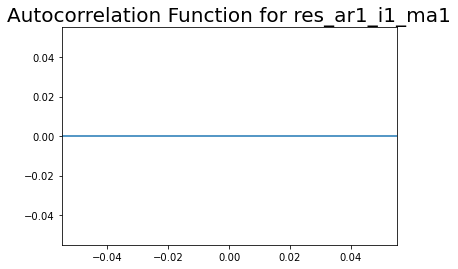

In [75]:
# Revisar Residuos
df["res_ar1_i1_ma1"] = results_ar1_i1_ma1.resid
sgt.plot_acf(df.res_ar1_i1_ma1,  zero=False, lags= 40)
plt.title("Autocorrelation Function for res_ar1_i1_ma1", size = 20)
plt.show()

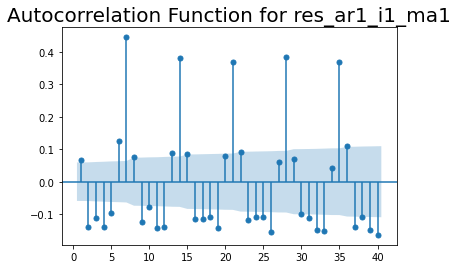

In [76]:
# Revisar Residuos
df["res_ar1_i1_ma1"] = results_ar1_i1_ma1.resid
sgt.plot_acf(df.res_ar1_i1_ma1[1:],  zero=False, lags= 40)
plt.title("Autocorrelation Function for res_ar1_i1_ma1", size = 20)
plt.show()

In [77]:
model_ar3_i1_ma3 = ARIMA(df.cantidad_pasos, order=(3,1,3))
results_ar3_i1_ma3 = model_ar3_i1_ma3.fit()
results_ar3_i1_ma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.cantidad_pasos   No. Observations:                 1094
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -10896.816
Method:                       css-mle   S.D. of innovations           5105.706
Date:                Tue, 19 Oct 2021   AIC                          21809.631
Time:                        16:46:02   BIC                          21849.612
Sample:                    01-02-2017   HQIC                         21824.760
                         - 12-31-2019                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -16.7940     10.718     -1.567      0.117     -37.800       4.212
ar.L1.D.cantidad_pasos     1.3824      0.005    273.672      0.000       1.372       1.392
ar.L2.D.cantidad_pasos    -1.1680      0.006   -187.082      0.000      -1.180      -1.156
ar.L3.D.cantidad_pasos     0.1348      0.005     26.957      0.000       0.125       0.145
ma.L1.D.cantidad_pasos    -2.1869      0.015   -150.031      0.000      -2.215      -2.158
ma.L2.D.cantidad_pasos     2.1593      0.020    109.104      0.000       2.121       2.198
ma.L3.D.cantidad_pasos    -0.9288      0.014    -67.620      0.000      -0.956      -0.902
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6239           -0.7817j            1.0001           -0.1428
AR.2            0.6239           +0.7817j            1.0001            0.1428
AR.3            7.4140           -0.0000j            7.4140           -0.0000
MA.1            0.6312           -0.7841j            1.0066           -0.1421
MA.2            0.6312           +0.7841j            1.0066            0.1421
MA.3            1.0626           -0.0000j            1.0626           -0.0000
-----------------------------------------------------------------------------
"""

In [78]:
start = len(train)
end = len(train) + len(test)-1
rename= f"results_ar3_i1_ma3 Predictions"

predictions_ar3_i1_ma3 = results_ar3_i1_ma3.predict(start=start, end=end, dynamic=False).rename(rename)

In [79]:
print(f'Lag: {predictions_ar3_i1_ma3}')
print(f'Coefficients: \n{results_ar3_i1_ma3.params}')

Lag: fecha
2019-05-27     743.800921
2019-05-28    -248.448667
2019-05-29     517.803526
2019-05-30     994.668685
2019-05-31    -462.287210
                 ...     
2019-12-27    1522.932083
2019-12-28   -2374.567674
2019-12-29    3520.938149
2019-12-30    6770.621718
2019-12-31    1498.495131
Freq: D, Name: results_ar3_i1_ma3 Predictions, Length: 219, dtype: float64
Coefficients: 
const                    -16.793971
ar.L1.D.cantidad_pasos     1.382392
ar.L2.D.cantidad_pasos    -1.167987
ar.L3.D.cantidad_pasos     0.134842
ma.L1.D.cantidad_pasos    -2.186871
ma.L2.D.cantidad_pasos     2.159316
ma.L3.D.cantidad_pasos    -0.928764
dtype: float64


In [80]:
labels = ["results_ar3_i1_ma3"]
preds = [predictions_ar3_i1_ma3]

for i in range(1):
    rmse = np.sqrt(mean_squared_error(test["cantidad_pasos"], preds[i]))
    print(f'{labels[i]} RMSE: {rmse:11.10}')

results_ar3_i1_ma3 RMSE: 39541.24081


In [81]:
model_ar7_i1_ma6 = ARIMA(df.cantidad_pasos, order=(7,1,6))
results_ar7_i1_ma6 = model_ar7_i1_ma6.fit(start_ar_lags=14)
results_ar7_i1_ma6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.cantidad_pasos   No. Observations:                 1094
Model:                 ARIMA(7, 1, 6)   Log Likelihood              -10805.753
Method:                       css-mle   S.D. of innovations           4679.470
Date:                Tue, 19 Oct 2021   AIC                          21641.507
Time:                        16:46:26   BIC                          21716.471
Sample:                    01-02-2017   HQIC                         21669.874
                         - 12-31-2019                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -9.0783     10.266     -0.884      0.377     -29.199      11.043
ar.L1.D.cantidad_pasos     0.0135      0.037      0.363      0.717      -0.060       0.087
ar.L2.D.cantidad_pasos    -0.5904      0.035    -16.819      0.000      -0.659      -0.522
ar.L3.D.cantidad_pasos    -0.5005      0.030    -16.879      0.000      -0.559      -0.442
ar.L4.D.cantidad_pasos    -0.0587      0.034     -1.729      0.084      -0.125       0.008
ar.L5.D.cantidad_pasos    -0.9432      0.026    -36.163      0.000      -0.994      -0.892
ar.L6.D.cantidad_pasos     0.2066      0.037      5.592      0.000       0.134       0.279
ar.L7.D.cantidad_pasos     0.0162      0.033      0.495      0.621      -0.048       0.080
ma.L1.D.cantidad_pasos    -0.7618      0.021    -35.871      0.000      -0.803      -0.720
ma.L2.D.cantidad_pasos     0.4671      0.017     27.062      0.000       0.433       0.501
ma.L3.D.cantidad_pasos     0.0225      0.023      0.992      0.321      -0.022       0.067
ma.L4.D.cantidad_pasos    -0.4241      0.023    -18.529      0.000      -0.469      -0.379
ma.L5.D.cantidad_pasos     0.8249      0.017     47.198      0.000       0.791       0.859
ma.L6.D.cantidad_pasos    -0.9263      0.019    -48.581      0.000      -0.964      -0.889
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0048           -0.0000j            1.0048           -0.5000
AR.2           -0.2217           -0.9754j            1.0003           -0.2856
AR.3           -0.2217           +0.9754j            1.0003            0.2856
AR.4            0.6239           -0.7817j            1.0002           -0.1428
AR.5            0.6239           +0.7817j            1.0002            0.1428
AR.6            3.7616           -0.0000j            3.7616           -0.0000
AR.7          -16.3044           -0.0000j           16.3044           -0.5000
MA.1           -1.0032           -0.0000j            1.0032           -0.5000
MA.2           -0.2145           -0.9768j            1.0001           -0.2844
MA.3           -0.2145           +0.9768j            1.0001            0.2844
MA.4            0.6315           -0.7852j            1.0077           -0.1422
MA.5            0.6315           +0.7852j            1.0077            0.1422
MA.6            1.0597           -0.0000j            1.0597           -0.0000
-----------------------------------------------------------------------------
"""

In [82]:
start = len(train)
end = len(train) + len(test)-1
rename= f"results_ar7_i1_ma6 Predictions"

predictions_ar7_i1_ma6 = results_ar7_i1_ma6.predict(start=start, end=end, dynamic=False).rename(rename)

In [83]:
print(f'Lag: {predictions_ar7_i1_ma6}')
print(f'Coefficients: \n{results_ar7_i1_ma6.params}')

Lag: fecha
2019-05-27    1077.815526
2019-05-28    1521.184584
2019-05-29      93.103918
2019-05-30    -132.155111
2019-05-31     832.040351
                 ...     
2019-12-27    1619.961238
2019-12-28   -2501.374248
2019-12-29    2956.383274
2019-12-30    6524.515922
2019-12-31    1565.167831
Freq: D, Name: results_ar7_i1_ma6 Predictions, Length: 219, dtype: float64
Coefficients: 
const                    -9.078270
ar.L1.D.cantidad_pasos    0.013548
ar.L2.D.cantidad_pasos   -0.590390
ar.L3.D.cantidad_pasos   -0.500537
ar.L4.D.cantidad_pasos   -0.058709
ar.L5.D.cantidad_pasos   -0.943165
ar.L6.D.cantidad_pasos    0.206593
ar.L7.D.cantidad_pasos    0.016212
ma.L1.D.cantidad_pasos   -0.761790
ma.L2.D.cantidad_pasos    0.467136
ma.L3.D.cantidad_pasos    0.022468
ma.L4.D.cantidad_pasos   -0.424092
ma.L5.D.cantidad_pasos    0.824868
ma.L6.D.cantidad_pasos   -0.926286
dtype: float64


In [84]:
labels = ["results_ar7_i1_ma6"]
preds = [predictions_ar7_i1_ma6]

for i in range(1):
    rmse = np.sqrt(mean_squared_error(test["cantidad_pasos"], preds[i]))
    print(f'{labels[i]} RMSE: {rmse:11.10}')

results_ar7_i1_ma6 RMSE: 39383.86528


In [85]:
model_ar6_i1_ma2 = ARIMA(df.cantidad_pasos, order=(6,1,2))
results_ar6_i1_ma2 = model_ar6_i1_ma2.fit(start_ar_lags=14)
results_ar6_i1_ma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.cantidad_pasos   No. Observations:                 1094
Model:                 ARIMA(6, 1, 2)   Log Likelihood              -10917.247
Method:                       css-mle   S.D. of innovations           5213.318
Date:                Tue, 19 Oct 2021   AIC                          21854.495
Time:                        16:46:29   BIC                          21904.471
Sample:                    01-02-2017   HQIC                         21873.406
                         - 12-31-2019                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -16.1935     33.959     -0.477      0.633     -82.752      50.365
ar.L1.D.cantidad_pasos    -0.7089      0.065    -10.944      0.000      -0.836      -0.582
ar.L2.D.cantidad_pasos    -0.7479      0.049    -15.263      0.000      -0.844      -0.652
ar.L3.D.cantidad_pasos    -0.6829      0.042    -16.367      0.000      -0.765      -0.601
ar.L4.D.cantidad_pasos    -0.6826      0.039    -17.426      0.000      -0.759      -0.606
ar.L5.D.cantidad_pasos    -0.6347      0.036    -17.405      0.000      -0.706      -0.563
ar.L6.D.cantidad_pasos    -0.4622      0.034    -13.651      0.000      -0.529      -0.396
ma.L1.D.cantidad_pasos     0.0559      0.070      0.796      0.426      -0.082       0.194
ma.L2.D.cantidad_pasos     0.0014      0.061      0.023      0.982      -0.118       0.121
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6603           -0.8360j            1.0653           -0.1436
AR.2            0.6603           +0.8360j            1.0653            0.1436
AR.3           -0.2602           -1.1046j            1.1349           -0.2868
AR.4           -0.2602           +1.1046j            1.1349            0.2868
AR.5           -1.0867           -0.5471j            1.2166           -0.4258
AR.6           -1.0867           +0.5471j            1.2166            0.4258
MA.1          -20.0184          -17.7480j           26.7531           -0.3846
MA.2          -20.0184          +17.7480j           26.7531            0.3846
-----------------------------------------------------------------------------
"""

In [86]:
start = len(train)
end = len(train) + len(test)-1
rename= f"results_ar6_i1_ma2 Predictions"

predictions_ar6_i1_ma2 = results_ar6_i1_ma2.predict(start=start, end=end, dynamic=False).rename(rename)

In [87]:
print(f'Lag: {predictions_ar6_i1_ma2}')
print(f'Coefficients: \n{results_ar6_i1_ma2.params}')

Lag: fecha
2019-05-27    2325.342197
2019-05-28    -418.361728
2019-05-29     589.114095
2019-05-30    1421.013293
2019-05-31     502.970605
                 ...     
2019-12-27    3094.835759
2019-12-28   -2743.967268
2019-12-29    2155.213768
2019-12-30    7356.667045
2019-12-31   -6306.327182
Freq: D, Name: results_ar6_i1_ma2 Predictions, Length: 219, dtype: float64
Coefficients: 
const                    -16.193515
ar.L1.D.cantidad_pasos    -0.708890
ar.L2.D.cantidad_pasos    -0.747859
ar.L3.D.cantidad_pasos    -0.682930
ar.L4.D.cantidad_pasos    -0.682558
ar.L5.D.cantidad_pasos    -0.634722
ar.L6.D.cantidad_pasos    -0.462189
ma.L1.D.cantidad_pasos     0.055939
ma.L2.D.cantidad_pasos     0.001397
dtype: float64


In [88]:
labels = ["results_ar6_i1_ma2"]
preds = [predictions_ar6_i1_ma2]

for i in range(1):
    rmse = np.sqrt(mean_squared_error(test["cantidad_pasos"], preds[i]))
    print(f'{labels[i]} RMSE: {rmse:11.10}')

results_ar6_i1_ma2 RMSE: 39340.95914


In [89]:
# Comparación de los Modelos

print("ARMA(7,6): \t LL = ", results_ar7_m6.llf, "\t AIC = ", results_ar7_m6.aic)
print("ARIMA(6,1): \t LL = ", results_ar6_i1_ma2.llf, "\t AIC = ", results_ar6_i1_ma2.aic)

ARMA(7,6): 	 LL =  -10820.27728054876 	 AIC =  21670.55456109752
ARIMA(6,1): 	 LL =  -10917.247480866272 	 AIC =  21854.494961732544


#### Comentarios:

Los resultados con el Modelo ARIMA son confusos y no entregan un mejor performance.
- La comparación de modelos da como resultado una mejor performance del modelo results_ar7_m6, pero se hace difícil comparar con el modelo Ganador del Proyecto 3, ya que no tienen la misma métrica.


### Modelo ARIMAX

Se transformarán los datos para utilzar el Modelo ARIMAX.

In [90]:
import statsmodels.tsa.stattools as sts

In [91]:
df["delta"] = df.cantidad_pasos.diff(1)

In [92]:
delta_ar1_i1_ma1 = ARIMA(df.delta[1:], order=(1,0,1))
resdelta_ar1_i1_ma1 = delta_ar1_i1_ma1.fit()
resdelta_ar1_i1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  delta   No. Observations:                 1094
Model:                     ARMA(1, 1)   Log Likelihood              -11047.175
Method:                       css-mle   S.D. of innovations           5871.745
Date:                Tue, 19 Oct 2021   AIC                          22102.350
Time:                        16:46:30   BIC                          22122.340
Sample:                    01-02-2017   HQIC                         22109.914
                         - 12-31-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -11.2717      6.269     -1.798      0.072     -23.559       1.015
ar.L1.delta     0.3140      0.030     10.384      0.000       0.255       0.373
ma.L1.delta    -0.9768      0.007   -142.731      0.000      -0.990      -0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1847           +0.0000j            3.1847            0.0000
MA.1            1.0238           +0.0000j            1.0238            0.0000
-----------------------------------------------------------------------------
"""

In [93]:
model_ar1_i1_ma1 = ARIMA(df.cantidad_pasos, order=(1,1,1))
results_ar1_i1_ma1 = model_ar1_i1_ma1.fit()
results_ar1_i1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.cantidad_pasos   No. Observations:                 1094
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11047.175
Method:                       css-mle   S.D. of innovations           5871.745
Date:                Tue, 19 Oct 2021   AIC                          22102.350
Time:                        16:46:31   BIC                          22122.340
Sample:                    01-02-2017   HQIC                         22109.914
                         - 12-31-2019                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -11.2717      6.269     -1.798      0.072     -23.559       1.015
ar.L1.D.cantidad_pasos     0.3140      0.030     10.384      0.000       0.255       0.373
ma.L1.D.cantidad_pasos    -0.9768      0.007   -142.731      0.000      -0.990      -0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1847           +0.0000j            3.1847            0.0000
MA.1            1.0238           +0.0000j            1.0238            0.0000
-----------------------------------------------------------------------------
"""

#### Comentario: La integración está bien realizada.

In [94]:
sts.adfuller(df.delta[1:])

(-12.713772322867706,
 1.0168409079133025e-23,
 19,
 1074,
 {'1%': -3.4364533503600962,
  '5%': -2.864234857527328,
  '10%': -2.568204837482531},
 21281.37684883692)

#### Comentario: La integración es estacionaria.

In [95]:
model_arimax111=ARIMA(df.cantidad_pasos, exog=df.resid_ar4_m3, order=(1,1,1))
results_arimax111 = model_arimax111.fit()
results_arimax111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.cantidad_pasos   No. Observations:                 1094
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10589.890
Method:                       css-mle   S.D. of innovations           3856.896
Date:                Tue, 19 Oct 2021   AIC                          21189.780
Time:                        16:46:32   BIC                          21214.768
Sample:                    01-02-2017   HQIC                         21199.235
                         - 12-31-2019                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    217.5877    304.301      0.715      0.475    -378.832     814.008
resid_ar4_m3               1.6980      0.002    734.697      0.000       1.693       1.703
ar.L1.D.cantidad_pasos     0.2342      0.030      7.923      0.000       0.176       0.292
ma.L1.D.cantidad_pasos     1.0000      0.004    268.718      0.000       0.993       1.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.2706           +0.0000j            4.2706            0.0000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

In [96]:
start = len(train)
end = len(train) + len(test)-1
rename= f"results_arimax111 Predictions"

predictions_arimax111 = results_arimax111.predict(start=start, end=end, dynamic=False).rename(rename)

In [97]:
print(f'Lag: {predictions_arimax111}')
print(f'Coefficients: \n{results_arimax111.params}')

Lag: fecha
2019-05-27     4717.029696
2019-05-28     1404.982799
2019-05-29     -153.456806
2019-05-30      -73.758017
2019-05-31     7996.574213
                  ...     
2019-12-27     3550.234322
2019-12-28   -13628.925593
2019-12-29    -9058.435989
2019-12-30     8963.043631
2019-12-31   -24433.018559
Freq: D, Name: results_arimax111 Predictions, Length: 219, dtype: float64
Coefficients: 
const                     217.587719
resid_ar4_m3                1.698006
ar.L1.D.cantidad_pasos      0.234161
ma.L1.D.cantidad_pasos      0.999999
dtype: float64


In [98]:
labels = ["results_arimax111"]
preds = [predictions_arimax111]

for i in range(1):
    rmse = np.sqrt(mean_squared_error(test["cantidad_pasos"], preds[i]))
    print(f'{labels[i]} RMSE: {rmse:11.10}')

results_arimax111 RMSE: 39483.05346


In [99]:
# Comparación de los Modelos

print("ARMA(7,6): \t LL = ", results_ar7_m6.llf, "\t AIC = ", results_ar7_m6.aic)
print("ARIMAX(1,1,1): \t LL = ", results_arimax111.llf, "\t AIC = ", results_arimax111.aic)

ARMA(7,6): 	 LL =  -10820.27728054876 	 AIC =  21670.55456109752
ARIMAX(1,1,1): 	 LL =  -10589.88986035241 	 AIC =  21189.77972070482


#### Comentarios:
Los resultados con el Modelo ARIMAX.

La comparación de modelos da como resultado una mejor performance del modelo ARIMAX(1,1,1), sobre el modelo ARMA(7,6), pero se hace difícil comparar con el modelo Ganador del Proyecto 3, ya que no tienen la misma métrica.

### Modelo SARIMAX

Se transformarán los datos para utilzar el Modelo SARIMAX.

In [100]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [101]:
model_sarimax = SARIMAX(df.cantidad_pasos, exog = df.resid_ar4_m3, order=(1,0,1), seasonal_order = (2,0,1,5))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    cantidad_pasos   No. Observations:                 1095
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood               -9886.628
Date:                           Tue, 19 Oct 2021   AIC                          19787.256
Time:                                   16:46:35   BIC                          19822.246
Sample:                               01-01-2017   HQIC                         19800.496
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
resid_ar4_m3     0.8498      0.001    612.065      0.000       0.847       0.852
ar.L1            0.9975      0.006    171.550      0.000       0.986       1.009
ma.L1            0.9988      0.012     85.137      0.000       0.976       1.022
ar.S.L5          0.8011      0.141      5.684      0.000       0.525       1.077
ar.S.L10         0.1955      0.057      3.452      0.001       0.084       0.306
ma.S.L5         -0.9981      0.134     -7.431      0.000      -1.261      -0.735
sigma2        5.904e+06   2.31e-08   2.55e+14      0.000     5.9e+06     5.9e+06
===================================================================================
Ljung-Box (L1) (Q):                 107.03   Jarque-Bera (JB):                 8.86
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.34   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.56e+29. Standard errors may be unstable.
"""

In [102]:
start = len(train)
end = len(train) + len(test)-1
rename= f"results_sarimax Predictions"

predictions_sarimax = results_sarimax.predict(start=start, end=end, dynamic=False).rename(rename)

In [103]:
print(f'Lag: {predictions_sarimax}')
print(f'Coefficients: \n{results_sarimax.params}')

Lag: fecha
2019-05-27    36797.735029
2019-05-28    38283.064582
2019-05-29    39458.302302
2019-05-30    41216.590118
2019-05-31    45123.803395
                  ...     
2019-12-27    40927.669320
2019-12-28    32680.522838
2019-12-29    27771.395877
2019-12-30    32867.875385
2019-12-31    21978.656206
Freq: D, Name: results_sarimax Predictions, Length: 219, dtype: float64
Coefficients: 
resid_ar4_m3    8.497666e-01
ar.L1           9.975441e-01
ma.L1           9.988056e-01
ar.S.L5         8.011212e-01
ar.S.L10        1.954709e-01
ma.S.L5        -9.981412e-01
sigma2          5.904181e+06
dtype: float64


In [104]:
labels = ["results_sarimax"]
preds = [predictions_sarimax]

for i in range(1):
    rmse = np.sqrt(mean_squared_error(test["cantidad_pasos"], preds[i]))
    print(f'{labels[i]} RMSE: {rmse:11.10}')

results_sarimax RMSE:  1220.69174


<AxesSubplot:xlabel='fecha'>

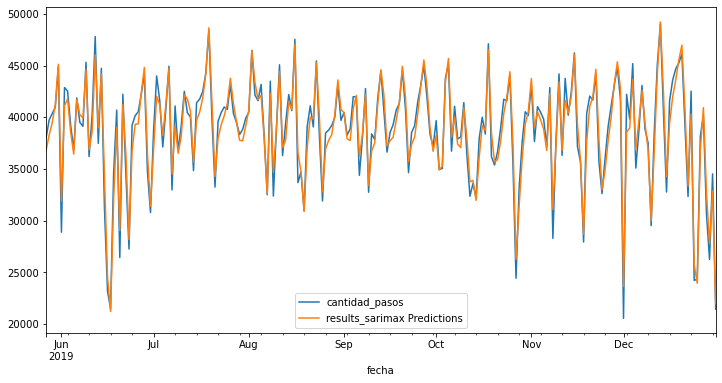

In [105]:
# Graficamos la predicción.

test["cantidad_pasos"].plot(legend=True)
predictions_sarimax.plot(legend=True, figsize =(12,6))

In [106]:
# Comparación de los Modelos

print("ARMA(7,6): \t LL = ", results_ar7_m6.llf, "\t AIC = ", results_ar7_m6.aic)
print("SARIMAX(1,1,1): \t LL = ", results_sarimax.llf, "\t AIC = ", results_sarimax.aic)

ARMA(7,6): 	 LL =  -10820.27728054876 	 AIC =  21670.55456109752
SARIMAX(1,1,1): 	 LL =  -9886.628164051694 	 AIC =  19787.256328103387


#### Comentarios:
Los resultados con el Modelo SARIMAX.

- El Modelo SARIMAX entrega muy buen RMSE 1220.69, inferior a los 4177.69 en Test del modelo Ganador del Proyecto 3.
- Por otra parte, también se presenta como mejor modelo frente al modelo ARMA(7,6).
- Al agregar el concepto estacional ha mejorado bastante el modelo.

# SEGUNDA PARTE

## Trabajar con un nuevo dataset

In [107]:
# Importando Data 
dataco2 = pd.read_csv('co2ppm.csv', sep =';')

In [108]:
dataco2.head()

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
0,1958-03-01,1.958.208,315.71,315.71,314.62,-1
1,1958-04-01,1.958.292,317.45,317.45,315.29,-1
2,1958-05-01,1.958.375,317.50,317.50,314.71,-1
3,1958-06-01,1.958.458,-99.99,317.10,314.85,-1
4,1958-07-01,1.958.542,315.86,315.86,314.98,-1


In [109]:
dataco2.tail()

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
722,2018-05-01,2.018.375,411.24,411.24,407.91,24
723,2018-06-01,2.018.458,410.79,410.79,408.49,29
724,2018-07-01,2.018.542,408.71,408.71,408.32,27
725,2018-08-01,2.018.625,406.99,406.99,408.90,30
726,2018-09-01,2.018.708,405.51,405.51,409.02,29


In [110]:
# Datos estadísticos generales del dataset.

dataco2.describe()


,Average,Interpolated,Trend,Number of Days
count,727.000000,727.000000,727.000000,727.000000
mean,349.555846,353.640702,353.633054,18.341128
std,52.068588,27.443136,27.369003,12.242015
min,-99.990000,312.660000,314.620000,-1.000000
25%,328.425000,328.555000,329.295000,-1.000000
50%,351.310000,351.310000,351.370000,24.000000
75%,375.700000,375.700000,376.135000,28.000000
max,411.240000,411.240000,409.020000,31.000000


In [111]:
# Auditoría del tipo de dato de cada features.

dataco2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            727 non-null    object 
 1   Decimal Date    727 non-null    object 
 2   Average         727 non-null    float64
 3   Interpolated    727 non-null    float64
 4   Trend           727 non-null    float64
 5   Number of Days  727 non-null    int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 34.2+ KB


In [112]:
# Revisión si existen datos nulos o faltantes.

dataco2.isnull().sum()

Date              0
Decimal Date      0
Average           0
Interpolated      0
Trend             0
Number of Days    0
dtype: int64

Comentarios: El dataset no tiene datos nulos.

In [113]:
# Se eliminan columnas que no se utilizarán en el análisis.

dataco2.drop(columns=['Decimal Date','Number of Days'], inplace = True)

In [114]:
data_co2 = dataco2.copy()

In [115]:
data_co2.head()

,Date,Average,Interpolated,Trend
0,1958-03-01,315.71,315.71,314.62
1,1958-04-01,317.45,317.45,315.29
2,1958-05-01,317.50,317.50,314.71
3,1958-06-01,-99.99,317.10,314.85
4,1958-07-01,315.86,315.86,314.98


In [116]:
#data_co2['Date'] = pd.to_datetime(data_co2['Date'])


In [117]:
#data_co2.info()

In [118]:
# Transfomar columna fecha a índice.


data_co2.index = pd.to_datetime(data_co2.Date)





# Se indica que la frecuencia es diaria.
data_co2 = data_co2.resample("MS").sum().copy()


In [119]:
data_co2.head()

,Average,Interpolated,Trend
Date,,,
1958-03-01,315.71,315.71,314.62
1958-04-01,317.45,317.45,315.29
1958-05-01,317.50,317.50,314.71
1958-06-01,-99.99,317.10,314.85
1958-07-01,315.86,315.86,314.98


In [120]:
data_co2.tail()

,Average,Interpolated,Trend
Date,,,
2018-05-01,411.24,411.24,407.91
2018-06-01,410.79,410.79,408.49
2018-07-01,408.71,408.71,408.32
2018-08-01,406.99,406.99,408.90
2018-09-01,405.51,405.51,409.02


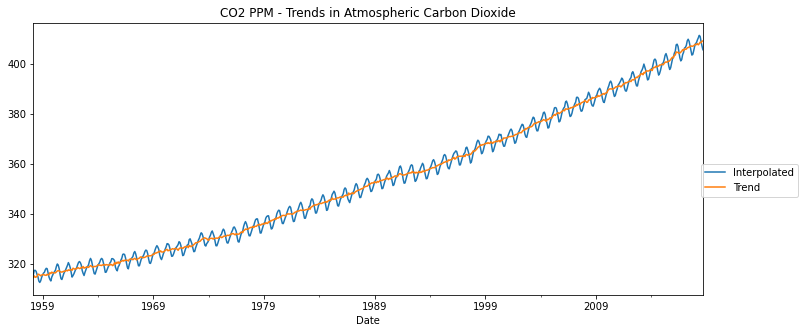

In [121]:
# Graficar la serie

title = "CO2 PPM - Trends in Atmospheric Carbon Dioxide"
xlabel = "Fecha"
ylabel = "CO2 PPM"

ax1=data_co2["Interpolated"].plot(figsize=(12,5), title=title);
ax2=data_co2["Trend"].plot();
ax.autoscale(axis="x", tight=True)
ax.set(xlabel = xlabel, ylabel = ylabel);
ax2.legend(bbox_to_anchor=(1.15, 0.5))

In [122]:
# Estacionariedad.

sts.adfuller(data_co2.Interpolated)

(4.774866785205458,
 1.0,
 20,
 706,
 {'1%': -3.439646367660705,
  '5%': -2.8656425177031375,
  '10%': -2.5689546724554404},
 494.90714335429107)

Comentario: La serie no es Estacionaria dado que el valor del estadístico de contraste es mayor a los datos de los niveles de significación.

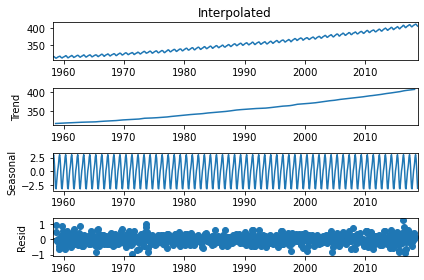

In [123]:
# Estacionalidad.
# Descomposición de la serie de tiempo.

dset_descomp = seasonal_decompose(data_co2['Interpolated'], model='additive')
dset_descomp.plot()
plt.show()

Comentarios: La descomposición no muestra un patrón de estacionalidad.

### Análisis ACF y PACF.

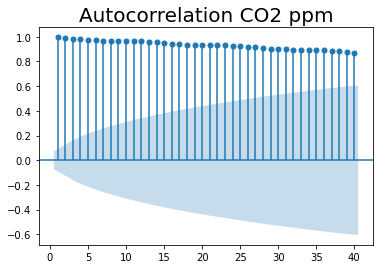

In [124]:
# Análisis de Autocorrelación.

sgt.plot_acf(data_co2.Interpolated, unbiased=True, zero=False, lags= 40)
plt.title("Autocorrelation CO2 ppm", size = 20)
plt.show()

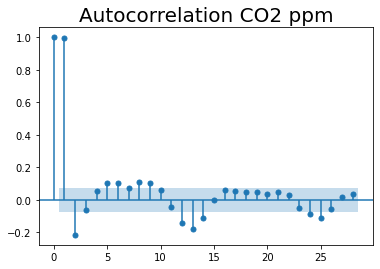

In [125]:
sgt.plot_pacf(data_co2.Interpolated.values, lags = 28, alpha=.05)
plt.title("Autocorrelation CO2 ppm", size = 20)
plt.show()

Comentario: De acuerdo ACF todas las observaciones (40) son relevantes. De acuerdo a PACF se podría tomar como relavantes hasta la observación 8 o 14, se debe analizar de acuerdo al modelo.

### Separar en Train y Test


In [126]:
len(data_co2)

727

In [127]:
727*0.8

581.6

In [128]:
train2 = data_co2.iloc[:581]
test2 = data_co2.iloc[581:]

## Modelo ARIMA y ARIMAX

Se utilizará el modelo ARIMA y ARIMAX para una primera aproximación.


In [129]:
modelco2_ar1_i1_ma1 = ARIMA(data_co2.Interpolated, order=(1,1,1))
resultado2_ar1_i1_ma1 = modelco2_ar1_i1_ma1.fit(start_ar_lags=3)
resultado2_ar1_i1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Interpolated   No. Observations:                  726
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -884.408
Method:                       css-mle   S.D. of innovations              0.818
Date:                Tue, 19 Oct 2021   AIC                           1776.816
Time:                        16:46:38   BIC                           1795.166
Sample:                    04-01-1958   HQIC                          1783.897
                         - 09-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1250      0.095      1.318      0.188      -0.061       0.311
ar.L1.D.Interpolated     0.5657      0.036     15.623      0.000       0.495       0.637
ma.L1.D.Interpolated     0.3604      0.034     10.556      0.000       0.293       0.427
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7677           +0.0000j            1.7677            0.0000
MA.1           -2.7749           +0.0000j            2.7749            0.5000
-----------------------------------------------------------------------------
"""

In [130]:
start = len(train2)
end = len(train2) + len(test2)-1
rename= f"resultado2_ar1_i1_ma1 Predictions"

predictionsco2_ar1_i1_ma1 = resultado2_ar1_i1_ma1.predict(start=start, end=end, dynamic=False).rename(rename)

In [131]:
print(f'Lag: {predictionsco2_ar1_i1_ma1}')
print(f'Coefficients: \n{resultado2_ar1_i1_ma1.params}')

Lag: Date
2006-08-01   -1.134565
2006-09-01   -1.435306
2006-10-01   -0.873153
2006-11-01    0.628240
2006-12-01    0.772480
                ...   
2018-05-01    0.457673
2018-06-01    0.815426
2018-07-01   -0.656303
2018-08-01   -1.635439
2018-09-01   -0.949203
Freq: MS, Name: resultado2_ar1_i1_ma1 Predictions, Length: 146, dtype: float64
Coefficients: 
const                   0.124991
ar.L1.D.Interpolated    0.565705
ma.L1.D.Interpolated    0.360368
dtype: float64


In [132]:
labels = ["resultado2_ar1_i1_ma1"]
preds = [predictionsco2_ar1_i1_ma1]

for i in range(1):
   rmse = np.sqrt(mean_squared_error(test2["Interpolated"], preds[i]))
   print(f'{labels[i]} RMSE: {rmse:11.10}')

resultado2_ar1_i1_ma1 RMSE: 394.7883997


In [133]:
# Graficamos la predicción.

#test2["Interpolated"].plot(legend=True)
#predictionsco2_ar1_i1_ma1.plot(legend=True, figsize =(12,6))

#### Modelo ARIMAX

In [134]:
modelco2_arimax=ARIMA(data_co2.Interpolated, exog=data_co2.Trend, order=(1,1,1))
resultado2_arimax = modelco2_arimax.fit(start_ar_lags=3)
resultado2_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Interpolated   No. Observations:                  726
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -884.178
Method:                       css-mle   S.D. of innovations              0.817
Date:                Tue, 19 Oct 2021   AIC                           1778.357
Time:                        16:46:38   BIC                           1801.295
Sample:                    04-01-1958   HQIC                          1787.209
                         - 09-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.7030      1.229     -0.572      0.567      -3.112       1.706
Trend                    0.0023      0.003      0.676      0.499      -0.004       0.009
ar.L1.D.Interpolated     0.5660      0.036     15.604      0.000       0.495       0.637
ma.L1.D.Interpolated     0.3608      0.034     10.572      0.000       0.294       0.428
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7669           +0.0000j            1.7669            0.0000
MA.1           -2.7716           +0.0000j            2.7716            0.5000
-----------------------------------------------------------------------------
"""

In [135]:
start = len(train2)
end = len(train2) + len(test2)-1
rename= f"resultado2_arimax Predictions"
predictions3_ar1_i1_max1 = resultado2_arimax.predict(start=start, end=end, dynamic=False).rename(rename)

In [136]:
print(f'Lag: {predictions3_ar1_i1_max1}')
print(f'Coefficients: \n{resultado2_arimax.params}')

Lag: Date
2006-08-01   -1.113896
2006-09-01   -1.414725
2006-10-01   -0.851476
2006-11-01    0.649848
2006-12-01    0.794876
                ...   
2018-05-01    0.499075
2018-06-01    0.857359
2018-07-01   -0.616882
2018-08-01   -1.594020
2018-09-01   -0.908323
Freq: MS, Name: resultado2_arimax Predictions, Length: 146, dtype: float64
Coefficients: 
const                  -0.702991
Trend                   0.002341
ar.L1.D.Interpolated    0.565965
ma.L1.D.Interpolated    0.360798
dtype: float64


In [137]:
labels = ["resultado2_arimax"]
preds = [predictions3_ar1_i1_max1]

for i in range(1):
   rmse = np.sqrt(mean_squared_error(test2["Interpolated"], preds[i]))
   print(f'{labels[i]} RMSE: {rmse:11.10}')

resultado2_arimax RMSE: 394.7573257


In [138]:
# Comparación de los Modelos

print("ARIMA(1,1,1): \t LL = ", resultado2_ar1_i1_ma1.llf, "\t AIC = ", resultado2_ar1_i1_ma1.aic)
print("ARIMAX(1,1,1): \t LL = ", resultado2_arimax.llf, "\t AIC = ", resultado2_arimax.aic)

ARIMA(1,1,1): 	 LL =  -884.4077683355662 	 AIC =  1776.8155366711323
ARIMAX(1,1,1): 	 LL =  -884.1784600451847 	 AIC =  1778.3569200903694


Comentario: No hay modelo claro Ganador.

In [139]:
modelco2_arimax9=ARIMA(data_co2.Interpolated, exog=data_co2.Trend, order=(4,2,4))
resultado_arimax9 = modelco2_arimax9.fit(start_ar_lags=1)
resultado_arimax9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D2.Interpolated   No. Observations:                  725
Model:                 ARIMA(4, 2, 4)   Log Likelihood                -814.972
Method:                       css-mle   S.D. of innovations              0.743
Date:                Tue, 19 Oct 2021   AIC                           1651.944
Time:                        16:46:40   BIC                           1702.392
Sample:                    05-01-1958   HQIC                          1671.414
                         - 09-01-2018                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0143      0.065      0.220      0.826      -0.113       0.142
Trend                 -4.025e-05      0.000     -0.219      0.827      -0.000       0.000
ar.L1.D2.Interpolated    -0.0438      0.033     -1.325      0.185      -0.109       0.021
ar.L2.D2.Interpolated     0.2163      0.132      1.641      0.101      -0.042       0.475
ar.L3.D2.Interpolated    -0.1610      0.106     -1.521      0.128      -0.369       0.046
ar.L4.D2.Interpolated    -0.2012      0.056     -3.589      0.000      -0.311      -0.091
ma.L1.D2.Interpolated    -0.0390        nan        nan        nan         nan         nan
ma.L2.D2.Interpolated    -0.2725      0.196     -1.389      0.165      -0.657       0.112
ma.L3.D2.Interpolated    -0.3417      0.060     -5.741      0.000      -0.458      -0.225
ma.L4.D2.Interpolated    -0.3081      0.050     -6.171      0.000      -0.406      -0.210
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9981           -0.9626j            1.3867           -0.1221
AR.2            0.9981           +0.9626j            1.3867            0.1221
AR.3           -1.3983           -0.7934j            1.6077           -0.4179
AR.4           -1.3983           +0.7934j            1.6077            0.4179
MA.1            1.0134           -0.0000j            1.0134           -0.0000
MA.2           -1.5145           -0.0000j            1.5145           -0.5000
MA.3           -0.3040           -1.4221j            1.4542           -0.2835
MA.4           -0.3040           +1.4221j            1.4542            0.2835
-----------------------------------------------------------------------------
"""

In [140]:
start = len(train2)
end = len(train2) + len(test2)-1
rename= f"resultado_arimax9 Predictions"

predictions_arimax9 = resultado_arimax9.predict(start=start, end=end, dynamic=False).rename(rename)

In [141]:
print(f'Lag: {predictions_arimax9}')
print(f'Coefficients: \n{resultado_arimax9.params}')

Lag: Date
2006-08-01   -0.073241
2006-09-01    1.247166
2006-10-01    0.778500
2006-11-01    0.504673
2006-12-01    0.457391
                ...   
2018-05-01    0.014129
2018-06-01   -0.512634
2018-07-01   -0.363726
2018-08-01    0.058313
2018-09-01    0.434050
Freq: MS, Name: resultado_arimax9 Predictions, Length: 146, dtype: float64
Coefficients: 
const                    0.014335
Trend                   -0.000040
ar.L1.D2.Interpolated   -0.043793
ar.L2.D2.Interpolated    0.216311
ar.L3.D2.Interpolated   -0.161033
ar.L4.D2.Interpolated   -0.201204
ma.L1.D2.Interpolated   -0.039006
ma.L2.D2.Interpolated   -0.272549
ma.L3.D2.Interpolated   -0.341705
ma.L4.D2.Interpolated   -0.308098
dtype: float64


In [142]:
labels = ["resultado_arimax9"]
preds = [predictions_arimax9]

for i in range(1):
   rmse = np.sqrt(mean_squared_error(test2["Interpolated"], preds[i]))
   print(f'{labels[i]} RMSE: {rmse:11.10}')

resultado_arimax9 RMSE: 394.9732969


Comentario: El modelo no mejora al aumentar el dato de AR y MA e interpolación.

### Modelo SARIMAX

In [143]:
model2_sarimax = SARIMAX(data_co2.Interpolated, exog=data_co2.Trend, order=(1,0,1), seasonal_order = (2,0,1,5))
results2_sarimax = model2_sarimax.fit()
results2_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      Interpolated   No. Observations:                  727
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood                -477.271
Date:                           Tue, 19 Oct 2021   AIC                            968.543
Time:                                   16:46:43   BIC                           1000.665
Sample:                               03-01-1958   HQIC                           980.938
                                    - 09-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Trend          1.0000      0.000   8723.831      0.000       1.000       1.000
ar.L1          0.5276      0.057      9.254      0.000       0.416       0.639
ma.L1          0.9756      0.017     56.082      0.000       0.941       1.010
ar.S.L5       -1.5534      0.029    -52.969      0.000      -1.611      -1.496
ar.S.L10      -0.8574      0.033    -25.944      0.000      -0.922      -0.793
ma.S.L5        0.8953      0.069     12.884      0.000       0.759       1.031
sigma2         0.2136      0.023      9.211      0.000       0.168       0.259
===================================================================================
Ljung-Box (L1) (Q):                 153.24   Jarque-Bera (JB):                50.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -0.08
Prob(H) (two-sided):                  0.03   Kurtosis:                         1.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [144]:
start = len(train2)
end = len(train2) + len(test2)-1
rename= f"results2_sarimax Predictions"

predictions2_sarimax = results2_sarimax.predict(start=start, end=end, dynamic=False).rename(rename)

In [145]:
print(f'Lag: {predictions2_sarimax}')
print(f'Coefficients: \n{results2_sarimax.params}')

Lag: Date
2006-08-01    381.166579
2006-09-01    378.752474
2006-10-01    378.780902
2006-11-01    379.543687
2006-12-01    381.731264
                 ...    
2018-05-01    410.796408
2018-06-01    411.135631
2018-07-01    409.458972
2018-08-01    407.768233
2018-09-01    405.348862
Freq: MS, Name: results2_sarimax Predictions, Length: 146, dtype: float64
Coefficients: 
Trend       0.999986
ar.L1       0.527611
ma.L1       0.975565
ar.S.L5    -1.553380
ar.S.L10   -0.857425
ma.S.L5     0.895290
sigma2      0.213646
dtype: float64


In [146]:
labels = ["results2_sarimax"]
preds = [predictions2_sarimax]

for i in range(1):
   rmse = np.sqrt(mean_squared_error(test2["Interpolated"], preds[i]))
   print(f'{labels[i]} RMSE: {rmse:11.10}')

results2_sarimax RMSE: 0.4947220843


In [147]:
# Graficamos la predicción.

#test["Interpolated"].plot(legend=True)
#predictions2_sarimax.plot(legend=True, figsize =(12,6)#)

Comentario: El Modelo SARIMAX predice demasiado bien los datos, con un error bajísimo.


In [148]:
# Comparación de los Modelos


print("ARIMAX(1,1,1): \t LL = ", resultado2_arimax.llf, "\t AIC = ", resultado2_arimax.aic)
print("SARIMAX(1,0,1): \t LL = ", results2_sarimax.llf, "\t AIC = ", results2_sarimax.aic)

ARIMAX(1,1,1): 	 LL =  -884.1784600451847 	 AIC =  1778.3569200903694
SARIMAX(1,0,1): 	 LL =  -477.2712836464023 	 AIC =  968.5425672928046


Comentario: El Modelo SARIMAX da muy buenos resultados en la predicción, claramente mejor que el modelo ARIMAX.